In [1]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import sagemaker
from sagemaker.model import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", 'us-east-1')
role

'arn:aws:iam::975050089157:role/service-role/SageMaker-bpv-ml-dev'

# Athena connection

In [3]:
from pyathena import connect

# Create a connection to Athena
conn = connect(s3_staging_dir='s3://bpv-dl-qa-athena-query-results',
               region_name='us-east-1',
               schema_name='bpv-dl-qa-glue-db-technical')

# Yahoo finance

In [4]:
# Execute the query and fetch the results into a pandas DataFrame
df = pd.read_sql_query('SELECT * FROM "bpv-dl-qa-glue-db-technical"."yf_spy_index" ORDER BY "date" ASC;', conn)

/tmp/ipykernel_143/1682436462.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('SELECT * FROM "bpv-dl-qa-glue-db-technical"."yf_spy_index" ORDER BY "date" ASC;', conn)


In [ ]:
df

# Top 20 

In [5]:
top_20_df_og = pd.read_sql_query('SELECT * FROM "bpv-dl-qa-glue-db-technical"."yf_top_20_tickers" ORDER BY ticker;', conn)

/tmp/ipykernel_143/1029822429.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top_20_df_og = pd.read_sql_query('SELECT * FROM "bpv-dl-qa-glue-db-technical"."yf_top_20_tickers" ORDER BY ticker;', conn)


In [ ]:
top_20_df_og

In [6]:
# Create a copy of the DataFrame
df_copy = top_20_df_og.copy()

# Set the index
df_copy.set_index(['date', 'ticker'], inplace=True)

# Check for duplicate indices
#assert not df_copy.index.duplicated().any(), "DataFrame copy has duplicate indices"

# Sentimental analysis

## financial_modeling_prep

In [ ]:
sentimental_df_fmp_og = pd.read_sql_query('SELECT * FROM "bpv-dl-qa-glue-db-news"."financial_modeling_prep";', conn)

In [ ]:
sentimental_df_fmp_og

## alphavantage

In [7]:
sentimental_df_av_og = pd.read_sql_query('SELECT "time_published", "title", "summary", "ticker", "source", "ticker_relevance_score", "ticker_sentiment_label" FROM "bpv-dl-qa-glue-db-news"."alphavantage" ORDER BY "time_published";', conn)

/tmp/ipykernel_143/72030502.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentimental_df_av_og = pd.read_sql_query('SELECT "time_published", "title", "summary", "ticker", "source", "ticker_relevance_score", "ticker_sentiment_label" FROM "bpv-dl-qa-glue-db-news"."alphavantage" ORDER BY "time_published";', conn)


In [ ]:
sentimental_df_av_og.head()

# Global economic conditions

In [8]:
glob_econ_cond_og = pd.read_sql_query(f"""SELECT * FROM "bpv-dl-qa-glue-db-fundamental"."global_economic_conditions" WHERE "unit" = 'percent' ORDER BY "date" ASC""", conn)

/tmp/ipykernel_143/1626883350.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  glob_econ_cond_og = pd.read_sql_query(f"""SELECT * FROM "bpv-dl-qa-glue-db-fundamental"."global_economic_conditions" WHERE "unit" = 'percent' ORDER BY "date" ASC""", conn)


In [ ]:
glob_econ_cond_og.head()

# VIX

In [9]:
vix_og = pd.read_sql_query('SELECT "date", "close" FROM "bpv-dl-qa-glue-db-technical"."yf_vix_index" ORDER BY "date" DESC;', conn)

/tmp/ipykernel_143/2320715156.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vix_og = pd.read_sql_query('SELECT "date", "close" FROM "bpv-dl-qa-glue-db-technical"."yf_vix_index" ORDER BY "date" DESC;', conn)


In [ ]:
vix_og.tail()

# Small business confidence

In [10]:
small_bus_conf_og = pd.read_sql_query('SELECT "monthyear", "opt_index" FROM "bpv-dl-qa-glue-db-fundamental"."nfib_small_business_confidence" ORDER BY "monthyear" ASC;', conn)

/tmp/ipykernel_143/2865663013.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  small_bus_conf_og = pd.read_sql_query('SELECT "monthyear", "opt_index" FROM "bpv-dl-qa-glue-db-fundamental"."nfib_small_business_confidence" ORDER BY "monthyear" ASC;', conn)


In [11]:
small_bus_conf = small_bus_conf_og.copy()
small_bus_conf = pd.DataFrame({
    'date' : small_bus_conf['monthyear'],
    'opt_index' : small_bus_conf['opt_index']
})

In [ ]:
small_bus_conf.head()

# Save datasets

In [ ]:
df.to_csv('yahoo_finance.csv', index=False)
top_20_df_og.to_csv('top_20.csv', index=False)
sentimental_df_fmp_og.to_csv('sentimental_analysis_financial_modeling_prep.csv', index=False)
sentimental_df_av_og.to_csv('sentimental_analysis_a.csv', index=False)

# Rating Top 20

In [ ]:
rating_top_20 = top_20_df_og[['ticker', 'rating']].drop_duplicates().sort_values(by='rating')
rating_top_20 = rating_top_20.reset_index()
rating_top_20 = rating_top_20[['ticker','rating']]

In [ ]:
rating_top_20

### Weighted average

In [ ]:
# Calculate weights and normalize
rating_top_20['weights'] = 20/rating_top_20['rating']/20

In [ ]:
rating_top_20

# Turn dates into index

In [12]:
data = df.copy()
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [ ]:
data

## Add Top 20 companies to dataframe

In [13]:
# Set 'date' and 'ticker' as a multi-index
top_20_df = top_20_df_og.copy()
top_20_df.set_index(['date', 'ticker'], inplace=True)

# Drop duplicate index entries
top_20_df = top_20_df.loc[~top_20_df.index.duplicated(keep='first')]

# Unstack the 'ticker' level of the index
new_data = top_20_df['close'].unstack('ticker')
new_data.index = pd.to_datetime(new_data.index)

# Merge the dataframes on the index
data = pd.concat([data, new_data], axis=1)

In [ ]:
data.tail()

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
data.columns

# Date vs Close chart

In [ ]:
plt.plot(data.index, data['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('S&P 500 Close Price Over Time')
plt.show()

# Adding columns and other features

## Column Variables

In [14]:
extras = ['sentiment', 'negative_sentiment', 'gec', 'vix','small_bus', 'all_features']
target_column = 'close_log_returns'
prediction_column = 'prediction_log_returns_top20'
prediction_features_columns = [f'prediction_log_returns_top20_{column}' for column in extras]

## Logarithmic returns

In [15]:
data[target_column] = np.log(data['close']/data['close'].shift(1))

In [ ]:
data

## Cumulative returns

In [ ]:
data['cumulative_log_returns'] = data[target_column].cumsum()

In [ ]:
data['cumulative_log_returns_prices'] = np.exp(data['cumulative_log_returns'])
data['cumulative_log_returns_prices'] = data['close'].iloc[0] * data['cumulative_log_returns_prices']

In [ ]:
data

In [ ]:
plt.plot(data.index, data['cumulative_log_returns'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('S&P 500 Close Price Over Time - Log returns')
plt.show()

## Logarithmic returns of tickers

In [16]:
for ticker in top_20_df_og['ticker'].unique():
    # Calculate the logarithmic returns for the current ticker
    data[ticker + '_log_return'] = np.log(data[ticker] / data[ticker].shift(1))

In [ ]:
data

## Sentimental features

### Regular

In [17]:
sentiment_to_value = {
    "Bearish": int(-2),
    "Somewhat-Bearish": int(-1),
    "Neutral": int(0),
    "Somewhat-Bullish": int(1),
    "Bullish": int(2),
}

In [18]:
sentimental_df_av = sentimental_df_av_og.copy()
# Drop duplicates
sentimental_df_av.drop_duplicates(inplace=True)
sentimental_df_av['ticker_sentiment_numerical_label'] = sentimental_df_av['ticker_sentiment_label'].map(sentiment_to_value)
# Convert 'time_published' to datetime and then to date
sentimental_df_av['time_published'] = pd.to_datetime(sentimental_df_av['time_published']).dt.date

# Convert 'ticker_sentiment_numerical_label' and 'ticker_relevance_score' to float
sentimental_df_av['ticker_sentiment_numerical_label'] = sentimental_df_av['ticker_sentiment_numerical_label'].astype(float)
sentimental_df_av['ticker_relevance_score'] = pd.to_numeric(sentimental_df_av['ticker_relevance_score'], errors='coerce')

# Calculate weighted sentiment score
sentimental_df_av['weighted_sentiment'] = sentimental_df_av['ticker_sentiment_numerical_label'] * sentimental_df_av['ticker_relevance_score']

# Group by date and calculate sum of weighted sentiment scores and sum of relevance scores
grouped = sentimental_df_av.groupby('time_published').agg({'weighted_sentiment': 'sum', 'ticker_relevance_score': 'sum'})

# Reset the index
grouped.reset_index(inplace=True)

# Calculate average weighted sentiment score
grouped['avg_weighted_sentiment'] = grouped['weighted_sentiment'] / grouped['ticker_relevance_score']

# Create a new DataFrame
sentimental_df_av = pd.DataFrame({
    'date': grouped['time_published'],
    'avg_weighted_sentiment': grouped['avg_weighted_sentiment'],
})
sentimental_df_av.set_index('date', inplace=True)

In [19]:
# Merge the two dataframes on date
data = pd.merge(data, sentimental_df_av['avg_weighted_sentiment'], left_index=True, right_index=True, how='left')
data = data.fillna(0)

# Fill missing values
data.ffill(inplace=True)

### Negative

In [20]:
negative_sentiment_to_value = {
    "Bearish": int(2),
    "Somewhat-Bearish": int(1),
    "Neutral": int(0),
    "Somewhat-Bullish": int(-1),
    "Bullish": int(-2),
}

In [21]:
negative_sentimental_df_av = sentimental_df_av_og.copy()

# Drop duplicates
negative_sentimental_df_av.drop_duplicates(inplace=True)

# Map sentiment labels to numerical values
negative_sentimental_df_av['ticker_negative_sentiment_numerical_label'] = negative_sentimental_df_av['ticker_sentiment_label'].map(negative_sentiment_to_value)

# Convert 'time_published' to datetime and then to date
negative_sentimental_df_av['time_published'] = pd.to_datetime(negative_sentimental_df_av['time_published']).dt.date

# Convert 'ticker_negative_sentiment_numerical_label' and 'ticker_relevance_score' to float
negative_sentimental_df_av['ticker_negative_sentiment_numerical_label'] = negative_sentimental_df_av['ticker_negative_sentiment_numerical_label'].astype(float)
negative_sentimental_df_av['ticker_relevance_score'] = pd.to_numeric(negative_sentimental_df_av['ticker_relevance_score'], errors='coerce')

# Calculate weighted sentiment score
negative_sentimental_df_av['negative_weighted_sentiment'] = negative_sentimental_df_av['ticker_negative_sentiment_numerical_label'] * negative_sentimental_df_av['ticker_relevance_score']

# Group by date and calculate sum of weighted sentiment scores and sum of relevance scores
grouped = negative_sentimental_df_av.groupby('time_published').agg({'negative_weighted_sentiment': 'sum', 'ticker_relevance_score': 'sum'})

# Reset the index
grouped.reset_index(inplace=True)

# Calculate average weighted sentiment score
grouped['avg_weighted_negative_sentiment'] = grouped['negative_weighted_sentiment'] / grouped['ticker_relevance_score']

# Create a new DataFrame
negative_sentimental_df_av = pd.DataFrame({
    'date': grouped['time_published'],
    'avg_weighted_negative_sentiment': grouped['avg_weighted_negative_sentiment'],
})

negative_sentimental_df_av.set_index('date', inplace=True)

In [22]:
# Merge the two dataframes on date
data = pd.merge(data, negative_sentimental_df_av['avg_weighted_negative_sentiment'], left_index=True, right_index=True, how='left')
data = data.fillna(0)

# Fill missing values
data.ffill(inplace=True)

In [ ]:
data.head()

## Add weights to log returns

In [ ]:
weighted_log_return_columns = [ticker + '_log_return_weighted' for ticker in top_20_df_og['ticker'].unique()]

In [ ]:
for index, row in rating_top_20.iterrows():
    ticker = row['ticker']
    weight = row['weights']
    data[ticker + '_log_return_weighted'] = data[ticker] * weight

In [ ]:
data.columns

## Add GEC

In [23]:
glob_econ_cond = glob_econ_cond_og.copy()
glob_econ_cond['date'] = pd.to_datetime(glob_econ_cond['date'])
glob_econ_cond = glob_econ_cond.set_index('date')
glob_econ_cond = glob_econ_cond[['value', 'unit', 'interval', 'function']]

In [ ]:
glob_econ_cond

### Unemployment percentage

In [24]:
# Filter rows where 'function' is 'UNEMPLOYMENT'
unemployment = glob_econ_cond[glob_econ_cond['function'] == 'UNEMPLOYMENT']

# Resample to monthly frequency and forward fill missing values
unemployment = unemployment.resample('D').ffill()

In [ ]:
unemployment

In [25]:
data['unemployment_percent'] = unemployment['value']

### Inflation

In [26]:
inflation = glob_econ_cond[glob_econ_cond['function'] == 'INFLATION']
inflation = inflation.resample('D').ffill()

In [ ]:
inflation

In [27]:
data['inflation_percent'] = inflation['value']

# Add Log return of VIX

In [28]:
vix = vix_og.copy()
vix = vix.drop_duplicates()
vix['date'] = pd.to_datetime(vix['date'])
vix = vix.set_index('date')
vix['log_return_vix'] = np.log(vix['close']/vix['close'].shift(1))

In [29]:
data['log_return_vix'] = vix['log_return_vix']

In [ ]:
data.head()

# Add small business confidence

In [30]:
small_bus_conf['date'] = pd.to_datetime(small_bus_conf['date'])
small_bus_conf = small_bus_conf.set_index('date')

In [31]:
small_bus_conf = small_bus_conf.resample('D').ffill()
data['small_bus'] = small_bus_conf['opt_index']

# Remove Nan

In [32]:
data.fillna(0, inplace=True)

In [ ]:
data

# Feature Column

In [33]:
# List of names for features
log_return_columns = [ticker + '_log_return' for ticker in top_20_df_og['ticker'].unique()]
models_feature_columns = [log_return_columns.copy() for i in range(7)]

feature_columns_name = ['avg_weighted_sentiment', 'avg_weighted_negative_sentiment', 'inflation_percent', 'unemployment_percent', 'log_return_vix', 'small_bus']


assignments = [
    (1, [0]),
    (2, [1]),
    (3, [2, 3]),
    (4, [4]),
    (5, [5]),
    (6, [0, 1, 2, 3, 4, 5])
]

for model_index, column_indices in assignments:
    for column_index in column_indices:
        models_feature_columns[model_index].append(feature_columns_name[column_index])

In [ ]:
data.columns

In [ ]:
selected_feature_index = 5

# Separate dataframes for models

In [34]:
df_features = [data.copy() for i in range(7)]
start_years = ["2000", "2000", "2022", "2022", "2000", "2000", "2000"]

# Size of partitions

In [35]:
# Business days frequency
freq = "B"


def prepare_data(data, year, window_size=10, train_ratio=0.95, test_year=None):
    # Filter data from the selected year onwards
    data = data.loc[year:]
    
    # Check if test_year is provided
    if test_year is not None:
        # Split the data at the start of test_year
        num_test_days = len(data.loc[test_year:])
        num_train_days = len(data) - num_test_days
    else:
        # Calculate the number of days
        total_days = len(data)
        num_train_days = int(total_days * train_ratio)
        num_test_days = total_days - num_train_days
    
    # Calculate the number of test windows
    num_test_windows = num_test_days // window_size
    
    # Get the start date of the dataset and the end dates of the training and test periods
    start_dataset = data.index[0]
    end_training = data.index[num_train_days - 1]
    end_test = data.index[-1]
    
    return start_dataset, end_training, end_test, num_train_days, num_test_days, num_test_windows, data

## New models partitions

In [36]:
window_size = 10
results = [prepare_data(data=df_features[i], year=start_years[i], window_size=window_size, train_ratio=0.95, test_year="2024") for i in range(7)]
start_datasets, end_trainings, end_tests, num_train_days, num_test_days, num_test_windows, new_dfs = zip(*results)

In [ ]:
training_date_ranges = []
all_training_data = []
all_test_data = []

for i in range(7):
    training_date_range = pd.date_range(start=start_datasets[i], end=end_trainings[i], freq=freq)
    filtered_training_date_range = [date for date in training_date_range if date in new_dfs[i].index]
    training_date_ranges.append(filtered_training_date_range)

    training_data = [
        {
            "start": str(filtered_training_date_range[0]),
            "target": new_dfs[i].loc[filtered_training_date_range[0]:filtered_training_date_range[-1], target_column].tolist(),
            "dynamic_feat": [new_dfs[i].loc[filtered_training_date_range[0]:filtered_training_date_range[-1], col].tolist() for col in models_feature_columns[i]]
        }
    ]
    all_training_data.append(training_data)

    test_date_range = pd.date_range(start=end_trainings[i] + pd.DateOffset(days=1), end=end_tests[i], freq=freq)
    filtered_test_date_range = [date for date in test_date_range if date in new_dfs[i].index]

    test_data = [
        {
            "start": str(date - pd.DateOffset(days=window_size)),
            "target": new_dfs[i].loc[date - pd.DateOffset(days=window_size):date, target_column].tolist(),
            "dynamic_feat": [new_dfs[i].loc[date - pd.DateOffset(days=window_size):date, col].tolist() for col in models_feature_columns[i]]
        }
        for date in filtered_test_date_range
    ]
    all_test_data.append(test_data)

In [ ]:
for i in range(7):
    print(f"Dataset {i+1}:")
    print(f"Training data length: {len(all_training_data[i])}")
    print(f"Test data length: {len(all_test_data[i])}")

## Standard models

In [ ]:
# Usage:
window_size = 10
start_dataset, end_training, end_test, num_train_days, num_test_days, num_test_windows, data = prepare_data(data=data, year='2000', window_size=window_size, test_year='2024')

In [ ]:
data.head()

In [ ]:
data.head()

### Train

In [ ]:
# Create a date range from start to end of training
training_date_range = pd.date_range(start=start_dataset, end=end_training, freq=freq)
# Filter out dates that are not in the DataFrame's index
training_date_range = [date for date in training_date_range if date in data.index]

##### Training with log returns from tickers

In [ ]:
# Convert DataFrame to list of dictionaries for training data
training_data = [
    {
        "start": str(training_date_range[0]),
        "target": data.loc[training_date_range[0]:training_date_range[-1], target_column].tolist(),
        "dynamic_feat": [data.loc[training_date_range[0]:training_date_range[-1], col].tolist() for col in models_feature_columns[selected_feature_index]]
    }
]
print(len(training_data))

### Test

In [ ]:
# Create a date range from start to end of training
test_date_range = pd.date_range(start=end_training + pd.DateOffset(days=1), end=end_test, freq=freq)
# Filter out dates that are not in the DataFrame's index
test_date_range = [date for date in test_date_range if date in data.index]

##### Test with log returns from tickers

In [ ]:
# Convert DataFrame to list of dictionaries for test data
test_data = [
    {
        "start": str(date - pd.DateOffset(days=window_size)),
        "target": data.loc[date - pd.DateOffset(days=window_size):date, target_column].tolist(),
        "dynamic_feat": [data.loc[date - pd.DateOffset(days=window_size):date, col].tolist() for col in models_feature_columns[selected_feature_index]]
    }
    for date in test_date_range
]
print(len(test_data))

# Write partitions to JSON and upload to S3

In [ ]:
def write_json_dataset(filename, data):
    with open(filename, 'wb') as f:
        for d in data:
            f.write(json.dumps(d).encode("utf-8"))
            f.write("\n".encode('utf-8'))

In [ ]:
s3 = boto3.resource("s3")

s3_bucket = 'bpv-dl-qa-analytics-s3'
s3_prefix = 'time_series/deep_ar'
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"
s3_data_path = f"s3://{s3_bucket}/{s3_prefix}"


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])

    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        s3.Bucket(bucket).put_object(Key=path, Body=data)

## Ensures each dynamic feature in the training and test datasets has the same length as the corresponding target

### Standard

In [ ]:
for dataset in [training_data, test_data]:
    for sample in dataset:
        if sample['target'] is not None:
            target_length = len(sample['target'])
            for i, feat in enumerate(sample['dynamic_feat']):
                # If the dynamic feature is shorter than the target, extend it with the last value
                if len(feat) < target_length:
                    sample['dynamic_feat'][i] += [feat[-1]] * (target_length - len(feat))
                # If the dynamic feature is longer than the target, truncate it
                elif len(feat) > target_length:
                    sample['dynamic_feat'][i] = feat[:target_length]

### New models

In [ ]:
for dataset in [all_training_data, all_test_data]:
    for data in dataset:
        for sample in data:
            if sample['target'] is not None:
                target_length = len(sample['target'])
                for i, feat in enumerate(sample['dynamic_feat']):
                    # Si la característica dinámica es más corta que el objetivo, extiéndela con el último valor
                    if len(feat) < target_length:
                        sample['dynamic_feat'][i] += [feat[-1]] * (target_length - len(feat))
                    # Si la característica dinámica es más larga que el objetivo, trúncala
                    elif len(feat) > target_length:
                        sample['dynamic_feat'][i] = feat[:target_length]

## Check consistency to train/test

In [ ]:
def check_dataset_consistency(train_dataset, test_dataset=None):
    d = train_dataset[0]
    has_dynamic_feat = "dynamic_feat" in d
    if has_dynamic_feat:
        num_dynamic_feat = len(d["dynamic_feat"])
    has_cat = "cat" in d
    if has_cat:
        num_cat = len(d["cat"])

    def check_ds(ds):
        for i, d in enumerate(ds):
            if has_dynamic_feat:
                assert "dynamic_feat" in d
                assert num_dynamic_feat == len(d["dynamic_feat"])
                for f in d["dynamic_feat"]:
                    if d["target"] is not None:
                        assert len(d["target"]) == len(f)
            if has_cat:
                assert "cat" in d
                assert len(d["cat"]) == num_cat

    check_ds(train_dataset)
    if test_dataset is not None:
        check_ds(test_dataset)

In [ ]:
for i in range(7):
    print(f"Checking dataset {i+1}")
    check_dataset_consistency(all_training_data[i], all_test_data[i])

In [ ]:
training_data[0]['dynamic_feat'][-2]

### Transform to JSON

In [ ]:
write_json_dataset("train.json", training_data)
write_json_dataset("test.json", test_data)

### Upload partitions to S3

In [ ]:
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

## Transform to JSON and upload to S3

In [ ]:
for i in range(7):
    train_filename = f"train_{i+1}.json"
    test_filename = f"test_{i+1}.json"
    
    # Escribir el conjunto de datos de entrenamiento y prueba a archivos JSON
    write_json_dataset(train_filename, all_training_data[i])
    write_json_dataset(test_filename, all_test_data[i])
    
    # Copiar los archivos JSON a S3
    copy_to_s3(train_filename, f"{s3_data_path}/train/{i+1}/train.json")
    copy_to_s3(test_filename, f"{s3_data_path}/test/{i+1}/test.json")

# Estimator 

In [ ]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    base_job_name="bpv-deepar-yfinance-deepar-small-bus-job",
    output_path=s3_output_path,
)

# Estimators

In [41]:
model_job_names = []
model_job_names = ["base"] + extras
model_job_names[2] = "nega-sentiment"
model_job_names[5] = "small-bus"
model_job_names[6] = "all-feat"
model_job_names

['base', 'sentiment', 'nega-sentiment', 'gec', 'vix', 'small-bus', 'all-feat']

In [ ]:
s3_output_paths = []
s3_output_paths = [f"s3://{s3_bucket}/{s3_prefix}/{i+1}/output" for i in range(len(model_job_names))]

In [ ]:
estimators = [
    sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    base_job_name=f"bpv-deepar-yfinance-deepar-{model_job_names[i]}-job",
    output_path=s3_output_paths[i],
) for i in range(len(model_job_names))
]

## Hyperparameters and training for new models

In [ ]:
context_length = window_size
prediction_length = 1

In [ ]:
hyperparameters = {
    "time_freq": 'D',
    "epochs": "300",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "dropout_rate": 0.1,
}

In [ ]:
for estimator in estimators:
    estimator.set_hyperparameters(**hyperparameters)

In [ ]:
data_channels_new_models = [{"train": f"{s3_data_path}/train/{i+1}/", "test": f"{s3_data_path}/test/{i+1}/"} for i in range(7)]

In [ ]:
def fit_estimator(estimator, data_channels):
    estimator.fit(inputs=data_channels, wait=True)
    return estimator

In [ ]:
for i in range(5, len(estimators)):
    fit_estimator(estimators[i], data_channels_new_models[i])

# Hyperparameters and training for old models

In [ ]:
context_length = window_size
prediction_length = 1

In [ ]:
hyperparameters = {
    "time_freq": 'D',
    "epochs": "300",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "dropout_rate": 0.1,
}

In [ ]:
estimator.set_hyperparameters(**hyperparameters)

In [ ]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

# Training Analytics

In [ ]:
from sagemaker import TrainingJobAnalytics

# Specify the training job name
job_name = 'bpv-deepar-yfinance-deepar-i9-job-2024-04-22-13-57-43-252'

# Create a TrainingJobAnalytics object for the training job
metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name).dataframe()

In [ ]:
metrics_dataframe

In [ ]:
metrics_dataframe['metric_name'].unique()

In [ ]:
import matplotlib.pyplot as plt

# Assuming metrics_dataframe is your DataFrame with the metrics.

# Filter the DataFrame by metric names
training_loss_df = metrics_dataframe[metrics_dataframe['metric_name'].isin(['train:loss:batch', 'train:loss'])]
validation_metrics_df = metrics_dataframe[metrics_dataframe['metric_name'].isin(['test:mean_wQuantileLoss', 'test:RMSE'])]

# Plot training loss
plt.figure(figsize=(12, 6))
for metric in ['train:loss:batch', 'train:loss']:
    subset = training_loss_df[training_loss_df['metric_name'] == metric]
    plt.plot(subset['timestamp'], subset['value'], label=metric)
plt.title('Training Loss Metrics')
plt.xlabel('Timestamp')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

print(f"Quantile loss: {metrics_dataframe['value'].iloc[0]}")
print(f"RMSE: {metrics_dataframe['value'].iloc[-1]}")

# DeepAR predictor class

This class transforms the JSON response from the model into more readable data

In [37]:
from sagemaker.serializers import IdentitySerializer


class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            #serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
        return [x if np.isfinite(x) else "NaN" for x in ts]

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

### Training made on previous step

In [ ]:
predictor_small_bus = estimator.deploy(
    initial_instance_count=1, instance_type="ml.t2.medium", predictor_cls=DeepARPredictor
)

### Create endpoints for new models

In [38]:
finished_training_job_names = ["bpv-deepar-yfinance-deepar-base-job-2024-07-25-15-13-56-960", 
                               "bpv-deepar-yfinance-deepar-sentiment-jo-2024-07-25-16-25-10-653",
                               "bpv-deepar-yfinance-deepar-nega-sentime-2024-07-25-18-21-06-781",
                               "bpv-deepar-yfinance-deepar-gec-job-2024-07-25-18-34-26-694",
                               "bpv-deepar-yfinance-deepar-vix-job-2024-07-25-18-47-46-176",
                               "bpv-deepar-yfinance-deepar-small-bus-jo-2024-07-25-20-38-18-031",
                               "bpv-deepar-yfinance-deepar-all-feat-job-2024-07-25-21-43-56-042"]

In [42]:
def deploy_model_from_training_job(training_job_name, endpoint_name_prefix, iteration):
    sagemaker_session = sagemaker.Session()
    
    # Retrieve the model artifact from the completed training job
    training_job_info = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
    model_data = training_job_info['ModelArtifacts']['S3ModelArtifacts']
    
    # Create a model object
    model = Model(
        model_data=model_data,
        role=sagemaker.get_execution_role(),
        image_uri=image_name,
        sagemaker_session=sagemaker_session,
        predictor_cls=DeepARPredictor
    )
    
    # Deploy the model to create an endpoint
    endpoint_name = f"{endpoint_name_prefix}-i{iteration}"
    predictor = model.deploy(
        initial_instance_count=1,
        instance_type="ml.t2.medium",
        endpoint_name=endpoint_name
    )
    
    return predictor

In [43]:
endpoint_name_prefixes = model_job_names.copy()

In [44]:
deployed_endpoints = []
for i in range(7):
    predictor = deploy_model_from_training_job(finished_training_job_names[i], endpoint_name_prefixes[i], 1)
    deployed_endpoints.append(predictor)

------------------------!----------------------!-------------------!----------------------!----------------------!------------------------!--------------------!

In [45]:
predictor_market = deployed_endpoints[0]
predictor_sentiment = deployed_endpoints[1]
predictor_negative_sentiment = deployed_endpoints[2]
predictor_gec = deployed_endpoints[3]
predictor_vix = deployed_endpoints[4]
predictor_small_bus = deployed_endpoints[5]
predictor_all_feat = deployed_endpoints[6]

### Endpoint already created

In [ ]:
endpoint_market = "base"
# Top20 model
# Create a DeepARPredictor object
predictor_market = DeepARPredictor(
    endpoint_name=endpoint_market,
    sagemaker_session=sagemaker.Session(),
)

In [ ]:
endpoint_sentiment = "sentiment"

#Top20 and sentiment model
# Create a DeepARPredictor object
predictor_sentiment = DeepARPredictor(
    endpoint_name=endpoint_sentiment,
    sagemaker_session=sagemaker.Session(),
)

In [ ]:
endpoint_negative_sentiment = "nega-sentiment"

predictor_negative_sentiment = DeepARPredictor(
    endpoint_name=endpoint_negative_sentiment,
    sagemaker_session=sagemaker.Session(),
)

In [ ]:
endpoint_gec = "gec"

predictor_gec = DeepARPredictor(
    endpoint_name=endpoint_gec,
    sagemaker_session=sagemaker.Session(),
)

In [ ]:
endpoint_vix = "vix"

predictor_vix = DeepARPredictor(
    endpoint_name=endpoint_vix,
    sagemaker_session=sagemaker.Session(),
)

In [ ]:
endpoint_small_bus = "small-bus"

predictor_small_bus = DeepARPredictor(
    endpoint_name=endpoint_small_bus,
    sagemaker_session=sagemaker.Session(),
)

In [ ]:
endpoint_all_feat = "all-feat"

predictor_all_feat = DeepARPredictor(
    endpoint_name=endpoint_all_feat,
    sagemaker_session=sagemaker.Session(),
)

### Predictors

In [49]:
predictors = []
predictors = [predictor_market, predictor_sentiment, predictor_negative_sentiment, predictor_gec, predictor_vix, predictor_small_bus, predictor_all_feat]

### Append predictions to dataset

In [ ]:
data.tail()

In [46]:
prediction_columns = [prediction_column]
prediction_columns.extend(prediction_features_columns)
prediction_columns

['prediction_log_returns_top20',
 'prediction_log_returns_top20_sentiment',
 'prediction_log_returns_top20_negative_sentiment',
 'prediction_log_returns_top20_gec',
 'prediction_log_returns_top20_vix',
 'prediction_log_returns_top20_small_bus',
 'prediction_log_returns_top20_all_features']

In [47]:
new_dfs = list(new_dfs)

In [52]:
for prediction_column in prediction_columns:
    data[prediction_column] = np.nan

#### Predictions for test only

In [ ]:
for i in range(7):
    df = new_dfs[i]
    end_training = end_trainings[i]
    prediction_column = prediction_columns[i]

    for j in range(len(df.loc[:end_training]), len(df)):
        last_value = df.loc[df.index[j-1], target_column]
        ts = pd.Series(data=[last_value], index=pd.DatetimeIndex([df.index[j-1]], freq='D'))

        dynamic_feats = [
            df.loc[df.index[j-window_size]:df.index[j-1], col].tolist() for col in models_feature_columns[i]
        ]

        prediction = predictors[i].predict(ts=ts, dynamic_feat=dynamic_feats, quantiles=[0.5])['0.5'].iloc[0]

        data.at[df.index[j], prediction_column] = prediction

#### Prediction from the beginning

In [55]:
def predict_from_start(df, start_idx, end_idx, target_column, prediction_column, model_idx):
    for j in range(start_idx + window_size, end_idx):
        last_value = df.loc[df.index[j-1], target_column]
        ts = pd.Series(data=[last_value], index=pd.DatetimeIndex([df.index[j-1]], freq='D'))

        dynamic_feats = [
            df.loc[df.index[j-window_size]:df.index[j-1], col].tolist() for col in models_feature_columns[model_idx]
        ]

        prediction = predictors[model_idx].predict(ts=ts, dynamic_feat=dynamic_feats, quantiles=[0.5])['0.5'].iloc[0]

        data.at[df.index[j], prediction_column] = prediction

In [56]:
for i in range(7):
    df = new_dfs[i]
    end_training = end_trainings[i]
    end_test = end_tests[i]
    prediction_column = prediction_columns[i]

    df = df.loc[~df.index.duplicated(keep='first')]

    predict_from_start(df, len(df.loc[:start_datasets[i]]), len(df.loc[:end_test]), target_column, prediction_column, i)

In [ ]:
len(models_feature_columns[0])

In [57]:
data.tail()

,open,high,low,close,adj close,volume,load_date_stage,ticker,dividends,stock splits,...,inflation_percent,log_return_vix,small_bus,prediction_log_returns_top20,prediction_log_returns_top20_sentiment,prediction_log_returns_top20_negative_sentiment,prediction_log_returns_top20_gec,prediction_log_returns_top20_vix,prediction_log_returns_top20_small_bus,prediction_log_returns_top20_all_features
date,,,,,,,,,,,,,,,,,,,,,
2024-04-24,506.559998,507.359985,503.135010,505.410004,505.410004,55394670,2024-04-24 21:47:00.885,SPY,0.0,0.0,...,0.0,0.038294,0.0,0.004982,0.006054,0.004242,0.009788,0.010198,-0.028921,-0.010193
2024-04-25,499.179993,504.269989,497.489990,503.489990,503.489990,68517479,2024-04-25 21:47:00.343,SPY,0.0,0.0,...,0.0,0.022369,0.0,-0.001330,-0.000993,-0.000798,-0.000371,-0.000878,-0.001419,-0.000810
2024-04-26,506.350006,509.880005,505.709991,508.260010,508.260010,64099172,2024-04-26 21:47:02.363,SPY,0.0,0.0,...,0.0,0.024244,0.0,-0.008423,-0.007425,-0.005515,-0.002389,-0.005465,-0.011211,-0.006819
2024-04-26,506.350006,509.880005,505.709991,508.260010,508.260010,64099172,2024-04-27 21:46:54.270,SPY,0.0,0.0,...,0.0,0.024244,0.0,-0.008423,-0.007425,-0.005515,-0.002389,-0.005465,-0.011211,-0.006819
2024-04-29,510.089996,510.750000,507.250000,510.059998,510.059998,40479293,2024-04-29 21:47:02.540,SPY,0.0,0.0,...,0.0,-0.064666,0.0,-0.009916,-0.005881,-0.004917,0.001712,-0.004534,-0.026660,-0.009067


In [58]:
data.head()

,open,high,low,close,adj close,volume,load_date_stage,ticker,dividends,stock splits,...,inflation_percent,log_return_vix,small_bus,prediction_log_returns_top20,prediction_log_returns_top20_sentiment,prediction_log_returns_top20_negative_sentiment,prediction_log_returns_top20_gec,prediction_log_returns_top20_vix,prediction_log_returns_top20_small_bus,prediction_log_returns_top20_all_features
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,95.401049,95.401049,92.585672,93.591164,0.0,8164300,2024-04-23 15:44:49.015,SPY,0.0,0.0,...,3.376857,-0.109441,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,92.364442,92.706309,89.860768,89.931152,0.0,8089800,2024-04-23 15:44:49.015,SPY,0.0,0.0,...,3.376857,0.022464,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,90.051829,91.077430,88.322383,90.092049,0.0,12177900,2024-04-23 15:44:49.015,SPY,0.0,0.0,...,3.376857,0.026085,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,89.850678,91.057267,88.644089,88.644089,0.0,6227200,2024-04-23 15:44:49.015,SPY,0.0,0.0,...,3.376857,0.169424,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,90.293104,93.792213,90.132226,93.792213,0.0,8066500,2024-04-23 15:44:49.015,SPY,0.0,0.0,...,3.376857,0.000461,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Add 'market' to extras list

In [59]:
extras = ['market'] + extras

In [60]:
extras

['market',
 'sentiment',
 'negative_sentiment',
 'gec',
 'vix',
 'small_bus',
 'all_features']

# Plot test results
This was for 2 models

### Test only

In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset


# Select the data from the day after the end of the training period to the end of the dataset
actual_data = data[target_column][end_training + DateOffset(days=1):]

for i in range(7):
    predicted_data = data[prediction_columns[i]][end_training + DateOffset(days=1):]

    plt.figure()  # Create a new figure
    plt.plot(actual_data.index, actual_data, label='Actual Log Close')
    plt.plot(predicted_data.index, predicted_data, label=f'Predicted Log Close({extras[i]})')
    plt.xlabel('Date')
    plt.ylabel('Log Close')
    plt.legend()
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better visibility
    plt.show()

### From the beginning

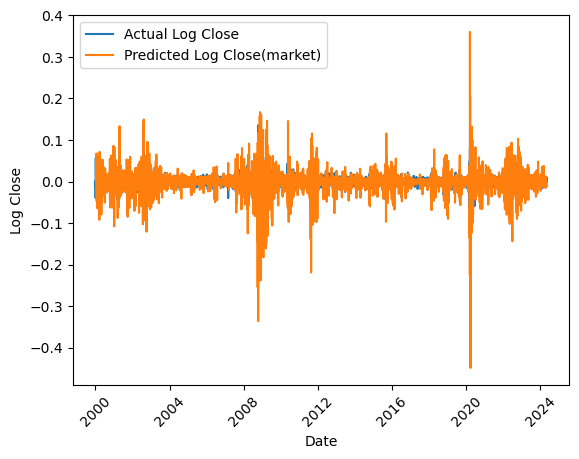

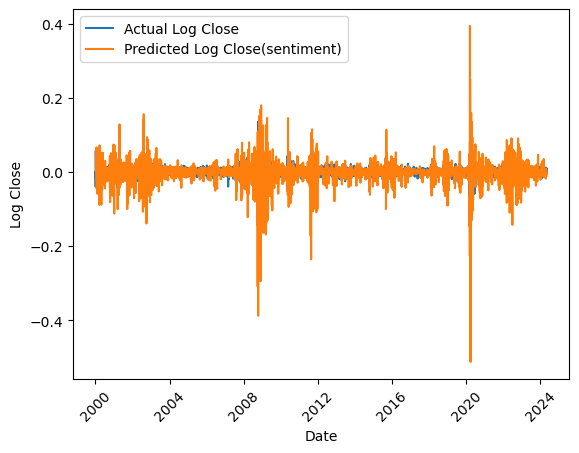

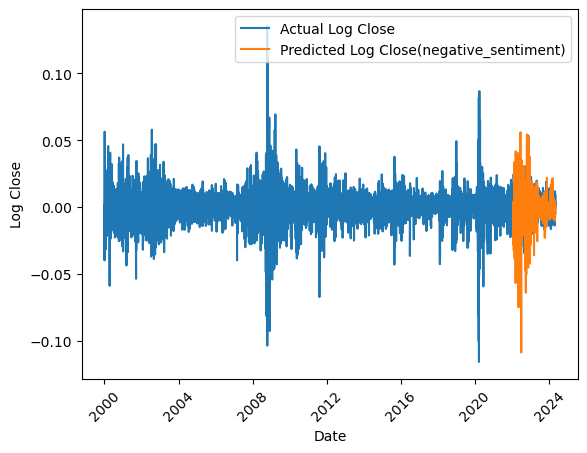

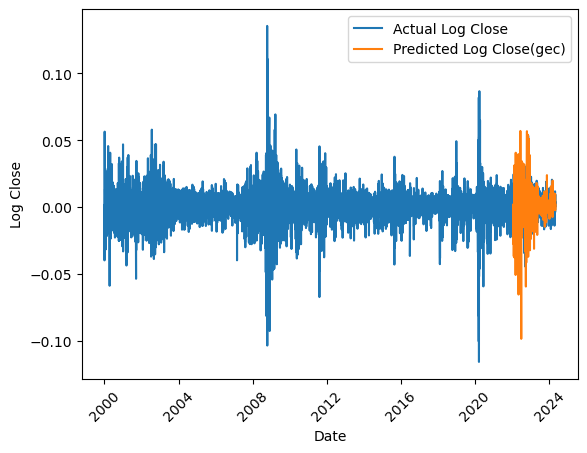

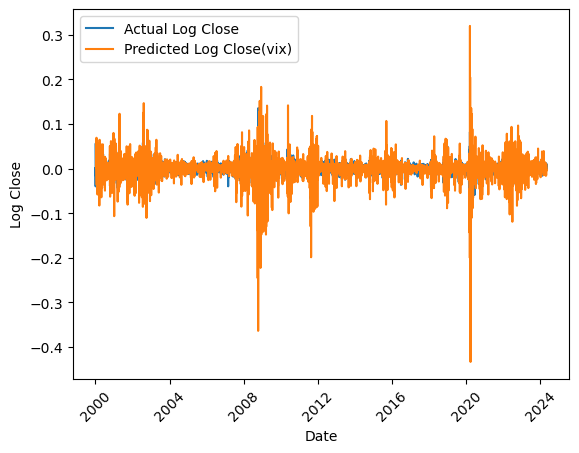

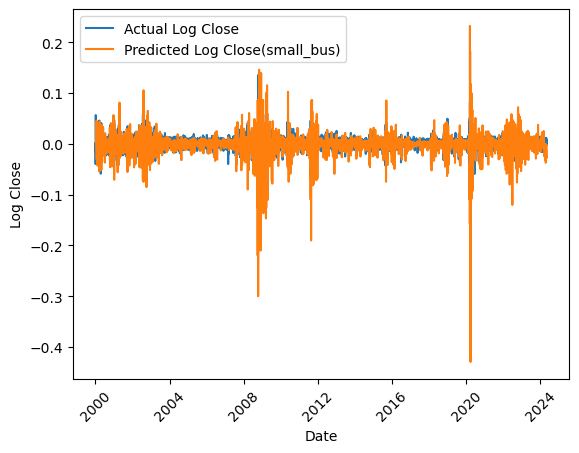

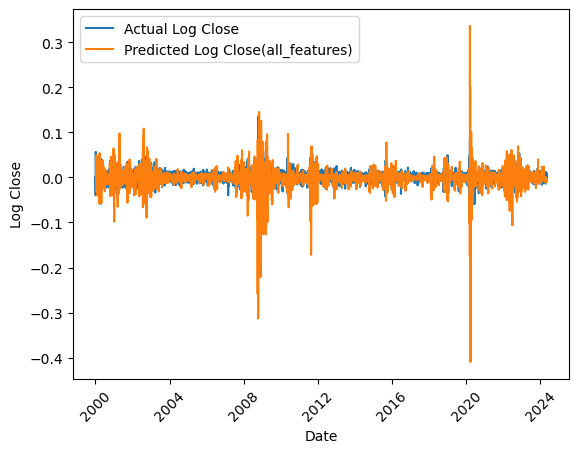

In [62]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

# Select the data from the start of the dataset
actual_data = data[target_column]

for i in range(7):
    predicted_data = data[prediction_columns[i]]

    plt.figure()  # Create a new figure
    plt.plot(actual_data.index, actual_data, label='Actual Log Close')
    plt.plot(predicted_data.index, predicted_data, label=f'Predicted Log Close({extras[i]})')
    plt.xlabel('Date')
    plt.ylabel('Log Close')
    plt.legend()
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better visibility
    plt.show()

# Reshape and organize dataframe

In [86]:
predicted_df = data.copy()

# If 'date' is the index, reset the index first
predicted_df = predicted_df.reset_index()

In [65]:
predicted_df.tail()

,date,open,high,low,close,adj close,volume,load_date_stage,ticker,dividends,...,inflation_percent,log_return_vix,small_bus,prediction_log_returns_top20,prediction_log_returns_top20_sentiment,prediction_log_returns_top20_negative_sentiment,prediction_log_returns_top20_gec,prediction_log_returns_top20_vix,prediction_log_returns_top20_small_bus,prediction_log_returns_top20_all_features
6115,2024-04-24,506.559998,507.359985,503.135010,505.410004,505.410004,55394670,2024-04-24 21:47:00.885,SPY,0.0,...,0.0,0.038294,0.0,0.004982,0.006054,0.004242,0.009788,0.010198,-0.028921,-0.010193
6116,2024-04-25,499.179993,504.269989,497.489990,503.489990,503.489990,68517479,2024-04-25 21:47:00.343,SPY,0.0,...,0.0,0.022369,0.0,-0.001330,-0.000993,-0.000798,-0.000371,-0.000878,-0.001419,-0.000810
6117,2024-04-26,506.350006,509.880005,505.709991,508.260010,508.260010,64099172,2024-04-26 21:47:02.363,SPY,0.0,...,0.0,0.024244,0.0,-0.008423,-0.007425,-0.005515,-0.002389,-0.005465,-0.011211,-0.006819
6118,2024-04-26,506.350006,509.880005,505.709991,508.260010,508.260010,64099172,2024-04-27 21:46:54.270,SPY,0.0,...,0.0,0.024244,0.0,-0.008423,-0.007425,-0.005515,-0.002389,-0.005465,-0.011211,-0.006819
6119,2024-04-29,510.089996,510.750000,507.250000,510.059998,510.059998,40479293,2024-04-29 21:47:02.540,SPY,0.0,...,0.0,-0.064666,0.0,-0.009916,-0.005881,-0.004917,0.001712,-0.004534,-0.026660,-0.009067


In [66]:
predicted_df.head()

,date,open,high,low,close,adj close,volume,load_date_stage,ticker,dividends,...,inflation_percent,log_return_vix,small_bus,prediction_log_returns_top20,prediction_log_returns_top20_sentiment,prediction_log_returns_top20_negative_sentiment,prediction_log_returns_top20_gec,prediction_log_returns_top20_vix,prediction_log_returns_top20_small_bus,prediction_log_returns_top20_all_features
0,2000-01-03,95.401049,95.401049,92.585672,93.591164,0.0,8164300,2024-04-23 15:44:49.015,SPY,0.0,...,3.376857,-0.109441,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,92.364442,92.706309,89.860768,89.931152,0.0,8089800,2024-04-23 15:44:49.015,SPY,0.0,...,3.376857,0.022464,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,90.051829,91.077430,88.322383,90.092049,0.0,12177900,2024-04-23 15:44:49.015,SPY,0.0,...,3.376857,0.026085,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,89.850678,91.057267,88.644089,88.644089,0.0,6227200,2024-04-23 15:44:49.015,SPY,0.0,...,3.376857,0.169424,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,90.293104,93.792213,90.132226,93.792213,0.0,8066500,2024-04-23 15:44:49.015,SPY,0.0,...,3.376857,0.000461,103.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Concatenate Dataframes

In [87]:
dfs = []

for i in range(len(extras)):
    # Create a DataFrame for predictions from prediction_column
    dfs.append(pd.DataFrame({
        'dates': predicted_df['date'],
        'actual_close': predicted_df['close'],
        'actual_log_close': predicted_df[target_column],
        'predicted_log_close': predicted_df[prediction_columns[i]],
        extras[i]: 1 
    }))

# Concatenate the DataFrames
predicted_df = pd.concat(dfs)

In [88]:
predicted_df.tail()

,dates,actual_close,actual_log_close,predicted_log_close,market,sentiment,negative_sentiment,gec,vix,small_bus,all_features
6115,2024-04-24,505.410004,-0.000475,-0.010193,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
6116,2024-04-25,503.489990,-0.003806,-0.000810,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
6117,2024-04-26,508.260010,0.009429,-0.006819,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
6118,2024-04-26,508.260010,0.000000,-0.006819,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
6119,2024-04-29,510.059998,0.003535,-0.009067,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [89]:
predicted_df.head()

,dates,actual_close,actual_log_close,predicted_log_close,market,sentiment,negative_sentiment,gec,vix,small_bus,all_features
0,2000-01-03,93.591164,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,89.931152,-0.039892,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,90.092049,0.001788,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,88.644089,-0.016203,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,93.792213,0.056452,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
#predicted_df = predicted_df.dropna(subset=['predicted_log_close'])
predicted_df = predicted_df.sort_values('dates')
predicted_df.fillna(0, inplace=True)

In [91]:
predicted_df.tail()

,dates,actual_close,actual_log_close,predicted_log_close,market,sentiment,negative_sentiment,gec,vix,small_bus,all_features
6119,2024-04-29,510.059998,0.003535,0.001712,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
6119,2024-04-29,510.059998,0.003535,-0.009916,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6119,2024-04-29,510.059998,0.003535,-0.026660,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
6119,2024-04-29,510.059998,0.003535,-0.004534,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
6119,2024-04-29,510.059998,0.003535,-0.009067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [92]:
predicted_df.head()

,dates,actual_close,actual_log_close,predicted_log_close,market,sentiment,negative_sentiment,gec,vix,small_bus,all_features
0,2000-01-03,93.591164,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,2000-01-03,93.591164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
0,2000-01-03,93.591164,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
0,2000-01-03,93.591164,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,2000-01-03,93.591164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


# Add success column

In [93]:
# Create a new column 'success'
predicted_df['success'] = np.where((predicted_df['actual_log_close'] > 0) & (predicted_df['predicted_log_close'] > 0), 1,
                           np.where((predicted_df['actual_log_close'] < 0) & (predicted_df['predicted_log_close'] < 0), 1, 0))

In [94]:
# Iterate over all values in extras
for extra in extras:
    # Filter DataFrame for the current extra value
    df_source = predicted_df[predicted_df[extra] == 1]

    # Calculate the success rate for the current extra value
    success_rate = (df_source['success'] == 1).sum() / len(df_source) * 100
    print(f"Success rate for Model Top 20 ({extra}): {success_rate}%")

Success rate for Model Top 20 (market): 50.01633986928105%
Success rate for Model Top 20 (sentiment): 50.37581699346405%
Success rate for Model Top 20 (negative_sentiment): 4.705882352941177%
Success rate for Model Top 20 (gec): 4.754901960784314%
Success rate for Model Top 20 (vix): 50.89869281045751%
Success rate for Model Top 20 (small_bus): 51.24183006535947%
Success rate for Model Top 20 (all_features): 49.19934640522875%


In [95]:
predicted_df.tail()

,dates,actual_close,actual_log_close,predicted_log_close,market,sentiment,negative_sentiment,gec,vix,small_bus,all_features,success
6119,2024-04-29,510.059998,0.003535,0.001712,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1
6119,2024-04-29,510.059998,0.003535,-0.009916,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6119,2024-04-29,510.059998,0.003535,-0.026660,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0
6119,2024-04-29,510.059998,0.003535,-0.004534,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0
6119,2024-04-29,510.059998,0.003535,-0.009067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0


# Append results to predicted_df

In [96]:
# Create a copy of the original DataFrame
predicted_df_copy = predicted_df.copy()

# Create an empty DataFrame to store the results
results_df = pd.DataFrame()

# Iterate over all values in extras
for extra in extras:
    # Filter DataFrame for the current extra value
    df_source = predicted_df_copy[predicted_df_copy[extra] == 1].copy()

    # Calculate cumulative log returns for the current extra value
    df_source['predicted_cumulative_log_returns'] = df_source['predicted_log_close'].cumsum()
    df_source['predicted_cumulative_log_returns_prices'] = np.exp(df_source['predicted_cumulative_log_returns'])
    df_source['predicted_cumulative_log_returns_prices'] = df_source['actual_close'].iloc[0] * df_source['predicted_cumulative_log_returns_prices']

    # Append the results to the results DataFrame
    results_df = pd.concat([results_df, df_source])

results_df.tail()

,dates,actual_close,actual_log_close,predicted_log_close,market,sentiment,negative_sentiment,gec,vix,small_bus,all_features,success,predicted_cumulative_log_returns,predicted_cumulative_log_returns_prices
6115,2024-04-24,505.410004,-0.000475,-0.010193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,-10.617036,0.002293
6116,2024-04-25,503.489990,-0.003806,-0.000810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,-10.617846,0.002291
6117,2024-04-26,508.260010,0.009429,-0.006819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,-10.624665,0.002275
6118,2024-04-26,508.260010,0.000000,-0.006819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,-10.631483,0.002260
6119,2024-04-29,510.059998,0.003535,-0.009067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,-10.640550,0.002239


In [97]:
# Replace the original DataFrame with the results DataFrame
predicted_df = results_df

In [98]:
# Calculate 'predicted_behaviour' and 'actual_behaviour'
predicted_df['predicted_behaviour'] = np.where(predicted_df['predicted_log_close'] > 0, 'up', 'down')
predicted_df['actual_behaviour'] = np.where(predicted_df['actual_log_close'] > 0, 'up', 'down')

In [76]:
predicted_df.tail()

,dates,actual_close,actual_log_close,predicted_log_close,market,sentiment,negative_sentiment,gec,vix,small_bus,all_features,success,predicted_cumulative_log_returns,predicted_cumulative_log_returns_prices,predicted_behaviour,actual_behaviour
6115,2024-04-24,505.410004,-0.000475,-0.010193,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,-10.617036,0.002317,down,down
6116,2024-04-25,503.489990,-0.003806,-0.000810,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,-10.617846,0.002315,down,down
6117,2024-04-26,508.260010,0.009429,-0.006819,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,-10.624665,0.002300,down,up
6118,2024-04-26,508.260010,0.000000,-0.006819,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,-10.631483,0.002284,down,down
6119,2024-04-29,510.059998,0.003535,-0.009067,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,-10.640550,0.002263,down,up


In [99]:
# Define the new order of columns
new_column_order = []
new_column_order = ['dates', 'actual_close', 'actual_log_close', 'predicted_log_close', 
                    'predicted_cumulative_log_returns', 'predicted_cumulative_log_returns_prices', 
                    'predicted_behaviour', 'actual_behaviour']
new_column_order = new_column_order + extras + ['success']

# Reorder the columns
predicted_df = predicted_df[new_column_order]

In [78]:
predicted_df.tail()

,dates,actual_close,actual_log_close,predicted_log_close,predicted_cumulative_log_returns,predicted_cumulative_log_returns_prices,predicted_behaviour,actual_behaviour,market,sentiment,negative_sentiment,gec,vix,small_bus,all_features,success
6115,2024-04-24,505.410004,-0.000475,-0.010193,-10.617036,0.002317,down,down,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
6116,2024-04-25,503.489990,-0.003806,-0.000810,-10.617846,0.002315,down,down,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
6117,2024-04-26,508.260010,0.009429,-0.006819,-10.624665,0.002300,down,up,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
6118,2024-04-26,508.260010,0.000000,-0.006819,-10.631483,0.002284,down,down,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
6119,2024-04-29,510.059998,0.003535,-0.009067,-10.640550,0.002263,down,up,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [100]:
mapping_dict = {
    extras[0]: 'Market data only',
    extras[1]: 'With news sentiment',
    extras[2]: 'With news sentiment (Inverted)',
    extras[3]: 'With Global Economic Conditions',
    extras[4]: 'With Options and Volatility Index',
    extras[5]: 'With Small Business Optimism Index',
    extras[6]: 'With All Features',
}

In [101]:
# Create the new 'model' column
for extra in extras:
    predicted_df.loc[predicted_df[extra] == 1, 'model'] = mapping_dict[extra]

# Drop the extras columns
predicted_df = predicted_df.drop(columns=extras)

/tmp/ipykernel_143/2450501689.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_df.loc[predicted_df[extra] == 1, 'model'] = mapping_dict[extra]


In [81]:
predicted_df.tail()

,dates,actual_close,actual_log_close,predicted_log_close,predicted_cumulative_log_returns,predicted_cumulative_log_returns_prices,predicted_behaviour,actual_behaviour,success,model
6115,2024-04-24,505.410004,-0.000475,-0.010193,-10.617036,0.002317,down,down,1,With All Features
6116,2024-04-25,503.489990,-0.003806,-0.000810,-10.617846,0.002315,down,down,1,With All Features
6117,2024-04-26,508.260010,0.009429,-0.006819,-10.624665,0.002300,down,up,0,With All Features
6118,2024-04-26,508.260010,0.000000,-0.006819,-10.631483,0.002284,down,down,0,With All Features
6119,2024-04-29,510.059998,0.003535,-0.009067,-10.640550,0.002263,down,up,0,With All Features


# Format decimals to avoid cientific notation

In [102]:
cols_to_round = ['actual_close', 'actual_log_close', 'predicted_log_close', 
                 'predicted_cumulative_log_returns', 'predicted_cumulative_log_returns_prices']

# Set the float format option in pandas
pd.options.display.float_format = '{:.6f}'.format

# Round the specified columns to 6 decimal places
predicted_df[cols_to_round] = predicted_df[cols_to_round].astype(float)

In [103]:
predicted_df.head(10)

,dates,actual_close,actual_log_close,predicted_log_close,predicted_cumulative_log_returns,predicted_cumulative_log_returns_prices,predicted_behaviour,actual_behaviour,success,model
0,2000-01-03,93.591164,0.000000,0.000000,0.000000,93.591164,down,down,0,Market data only
1,2000-01-04,89.931152,-0.039892,0.000000,0.000000,93.591164,down,down,0,Market data only
2,2000-01-05,90.092049,0.001788,0.000000,0.000000,93.591164,down,up,0,Market data only
3,2000-01-06,88.644089,-0.016203,0.000000,0.000000,93.591164,down,down,0,Market data only
4,2000-01-07,93.792213,0.056452,0.000000,0.000000,93.591164,down,up,0,Market data only
5,2000-01-10,94.113983,0.003425,0.000000,0.000000,93.591164,down,up,0,Market data only
6,2000-01-11,92.987846,-0.012038,0.000000,0.000000,93.591164,down,down,0,Market data only
7,2000-01-12,92.062798,-0.009998,0.000000,0.000000,93.591164,down,down,0,Market data only
8,2000-01-13,93.309586,0.013452,0.000000,0.000000,93.591164,down,up,0,Market data only
9,2000-01-14,94.576469,0.013486,0.000000,0.000000,93.591164,down,up,0,Market data only


# Export the results in csv to S3

In [104]:
import boto3
from io import StringIO

bucket_name = 'bpv-dl-qa-analytics-s3'
prefix = 'time_series/results'
file_name = 'prediction_deepar_new_models_final.csv'

# Convert DataFrame to CSV
csv_buffer = StringIO()
predicted_df.to_csv(csv_buffer, index=False, float_format='%.6f')

# Create S3 resource
s3_resource = boto3.resource('s3')

# Upload CSV to S3
s3_resource.Object(bucket_name, f"{prefix}/{file_name}").put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'METQH28QTAZVD7DC',
  'HostId': 'QnTHuf/1ByPFJkKQ72NXiteWqowe82EQc1ag2wfa+RneOuf4NDW3XXBQO0wV9yI38J0FQaaXRYfQQACaQ4l3qYVL91u2l+gtY7sdV+pWEPY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'QnTHuf/1ByPFJkKQ72NXiteWqowe82EQc1ag2wfa+RneOuf4NDW3XXBQO0wV9yI38J0FQaaXRYfQQACaQ4l3qYVL91u2l+gtY7sdV+pWEPY=',
   'x-amz-request-id': 'METQH28QTAZVD7DC',
   'date': 'Tue, 30 Jul 2024 17:07:56 GMT',
   'x-amz-version-id': 'F__N.hzeoX.lSdlfoR.olgUraZtCkDq.',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"1a212d82752a7dc4c855aae448024b0b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1a212d82752a7dc4c855aae448024b0b"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'F__N.hzeoX.lSdlfoR.olgUraZtCkDq.'}